In [6]:
#default_exp autoencoder_icao

In [1]:
#export
from fastai import *
from fastai.vision import *
from pathlib import PosixPath
import cv2
from fastai.callbacks.hooks import *
from fastai.callbacks import *
from fastai.utils.mem import *
from facelib.core import save_inference, load_inference

from torchvision.models import vgg16_bn
from torchvision import models as torchmodels

In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
#         self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
#         self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
#         self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
#         self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
#         out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
#         self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
#         x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [3]:
# ResNet(BasicBlock, [2,2,2,2])

In [4]:
images_dir = Path('../data/vgg_frontal_faces_hd/')

In [5]:
def get_face_src():
    return (ImageImageList.from_folder(images_dir)
            .split_by_rand_pct(0.05, seed=42)
            .label_from_func(lambda x:x))

In [6]:
def get_data(src, size, bs=4, transforms=get_transforms(), tfm_y=True):
    data = (src.transform(transforms, size=size, tfm_y=tfm_y)
            .databunch(bs=bs)
            .normalize(imagenet_stats, do_y=tfm_y))
#     data.c = 3
    return data

In [7]:
p = 0.4
train_transforms = [
    rotate(degrees=(-5, 5), p=p),
    symmetric_warp(magnitude=(-0.1, 0.1), p=p),
    rand_zoom(scale=(0.95,1.05), p=p),
    brightness(change=(0.4, 0.6), p=p),
    contrast(scale=(0.8,1.2), p=p)
]

valid_transforms = [
    rotate(degrees=(-1, 1), p=0.0)
]
transforms = (train_transforms, valid_transforms)

In [8]:
src_size = np.array((224,224))
src = get_face_src()
data = get_data(src, src_size, bs=8, transforms=transforms)
data

ImageDataBunch;

Train: LabelList (154090 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: ../data/vgg_frontal_faces_hd;

Valid: LabelList (8109 items)
x: ImageImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: ../data/vgg_frontal_faces_hd;

Test: None

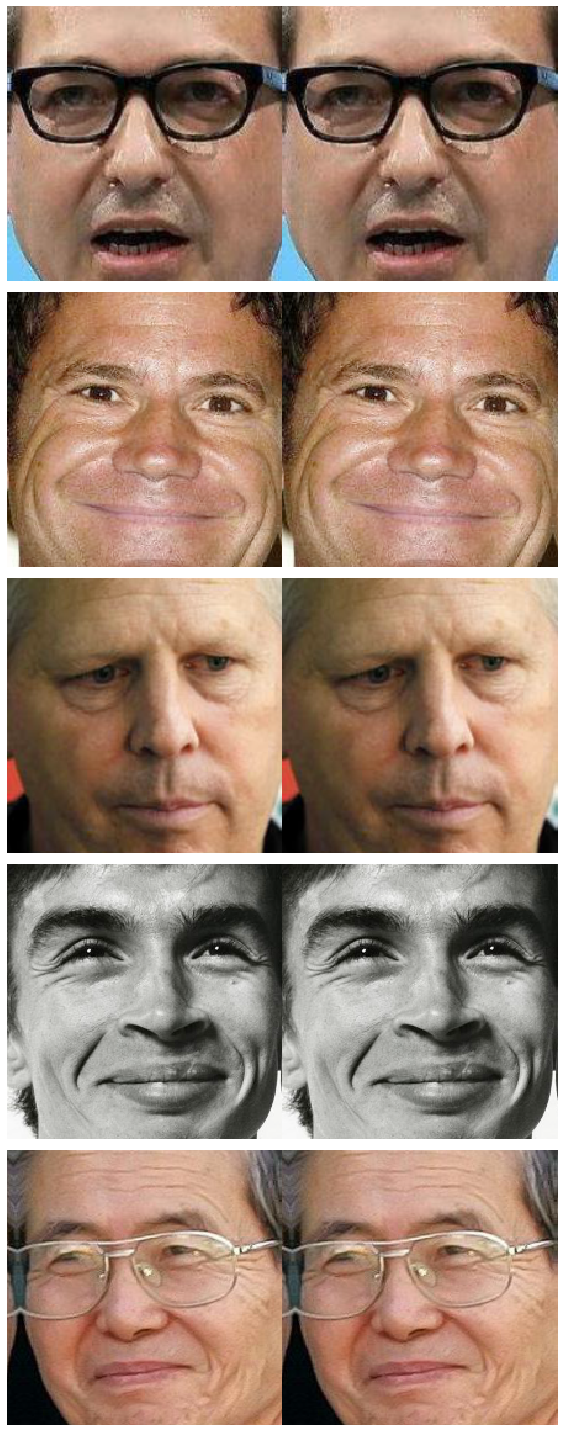

In [9]:
data.show_batch()

# Model

In [10]:
def save_torch_inference(model, path):
    torch.save(model.state_dict(), path)
    
def load_torch_inference(model, path, device=torch.device('cpu')):
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

In [35]:
class Expand(nn.Module):
    def __init__(self, *size): # w/out batch
        super().__init__()
        self.size = size
    def forward(self, x):
        return x.expand(x.shape[0], *self.size)
    
class Reshape(nn.Module):
    def __init__(self, *size):
        super().__init__()
        self.size = size
    def forward(self, x):
        return x.reshape(x.shape[0], *self.size)

class UpBlock(nn.Module):
    def __init__(self, ni, nf, scale=2):
        super().__init__()
        self.scale = scale
#         self.bn = batchnorm_2d(ni)
        self.conv1 = conv_layer(ni, nf)
        self.shuf = PixelShuffle_ICNR(ni=ni, nf=nf, scale=scale)
        self.conv2 = conv_layer(nf, nf)
        self.conv3 = conv_layer(nf*2, nf, ks=1)
        
    def forward(self, x_orig):
        x = self.conv1(x_orig)
        x1 = F.interpolate(x, tuple(tensor(x.shape[2:])*self.scale), mode='nearest')
        x = self.shuf(x_orig)
        x2 = self.conv2(x)
        return self.conv3(torch.cat([x1,x2], dim=1))
    
class DownBlock(nn.Module):
    def __init__(self, ni, nf, scale=2, ks=3):
        super().__init__()
        self.conv = conv_layer(ni, nf, ks=ks, stride=scale)
    
    def forward(self, x):
        return self.conv(x)

class AddLayer(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layer = nn.Sequential(*layers)
    def forward(self, x):
        return x + self.layer(x)
    
class Noise(nn.Module):
    def forward(self, x):
        return x + (torch.randn(*x.shape)/1000).to(x.device)

# def create_autoencoder(nfs_body = [3,16,32,32,64,128], nfs_head = [128,64,64,32,32,3]):
def create_autoencoder(nfs_body = [3,64,64,128,256,24], nfs_head = [24,512,256,128,64,3]):
    body = nn.Sequential(
#             create_body(models.resnet18, pretrained=True),
#             nn.Sequential(*list(torchmodels.resnet18(pretrained=True).children())[:-2]),
#             ResNet(BasicBlock, [2, 2, 2, 2]), # w/out bathnorm 
            nn.Sequential(*[DownBlock(ni,nf,scale=2) for ni,nf in zip(nfs_body[:-1], nfs_body[1:])]), # nn.Tanh(),
            Reshape(-1), *bn_drop_lin(24*7*7, 512, p=0.1, actn=None, bn=True), nn.Tanh(),
#             conv_layer(ni=512, nf=24, ks=1)
    )
    head = nn.Sequential(
#             nn.AdaptiveAvgPool2d([1,1]), Reshape(-1),
#             Noise(),
            *bn_drop_lin(512, 24*7*7, p=0.1, actn=None, bn=True), Reshape(24,7,7),
#             Reshape(-1), AddLayer(*bn_drop_lin(128*7*7, 128*7*7, p=0.1, actn=None)), Reshape(128,7,7),
#             conv_layer(ni=24, nf=512, ks=1, self_attention=False),
            nn.Sequential(*[UpBlock(ni,nf,scale=2) for ni,nf in zip(nfs_head[:-1], nfs_head[1:])])   
    )
    return nn.Sequential(body, head)

In [36]:
UpBlock(3,6)(torch.zeros(4,3,224,224)).shape, DownBlock(3,6)(torch.zeros(4,3,224,224)).shape

(torch.Size([4, 6, 448, 448]), torch.Size([4, 6, 112, 112]))

In [37]:
create_autoencoder()(torch.zeros(4,3,224,224)).shape

torch.Size([4, 3, 224, 224])

In [38]:
save_torch_inference(create_autoencoder()[0], '../models/temp.pth')

In [39]:
class ZeroOut(nn.Module):
    def __init__(self, h=None, w=None):
        super().__init__()
        self.h_slice, self.w_slice = h, w
    def forward(self, x):
        if self.h_slice is not None: x[:,:,self.h_slice,:] = 0
        if self.w_slice is not None: x[:,:,:,self.w_slice] = 0
        return x

def create_head(num_classes, zero_h=None, zero_w=None, body_nf=512, num_emb=128, p=.5):
    head = nn.Sequential(
#         ZeroOut(zero_h, zero_w), nn.BatchNorm2d(body_nf), nn.AdaptiveAvgPool2d([1,1]), Reshape(-1),
        ZeroOut(zero_h, zero_w), Reshape(-1),
        *bn_drop_lin(body_nf*7*7, num_emb, p=p, actn=nn.ReLU()), nn.Linear(num_emb, num_classes)
    )
#     head = nn.Sequential(
#         ZeroOut(zero_h, zero_w), conv_layer(ni=body_nf, nf=24, ks=1, norm_type=None), Reshape(-1),
#         *bn_drop_lin(24*7*7, num_emb, p=p, actn=nn.ReLU(), bn=True), nn.Linear(num_emb, num_classes)
#     )
#     apply_init(head, nn.init.kaiming_normal_)
    return head

In [40]:
create_head(10, body_nf=512)(torch.zeros(4,512,7,7)).shape

torch.Size([4, 10])

In [41]:
ZeroOut(h=[0,3,5], w=slice(0,3))(torch.ones(1,1,7,7))

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1.]]]])

# Feature Loss

In [42]:
t = data.train_ds[0][1].data
t = torch.stack([t,t])
t.shape

torch.Size([2, 3, 224, 224])

In [43]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)
gram_matrix(t).shape

torch.Size([2, 3, 3])

In [44]:
from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [45]:
base_loss = F.l1_loss
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = (['pixel',] + 
            [f'feat_{i}' for i in range(len(layer_ids))] + 
            [f'gram_{i}' for i in range(len(layer_ids))])

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [46]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Learner

In [47]:
src_size = np.array((224,224))
src = get_face_src()
data = get_data(src, src_size, bs=8, transforms=transforms)

In [48]:
model = create_autoencoder()
# loss_func = base_loss
loss_func = feat_loss
learner = Learner(data, model, loss_func=loss_func, callback_fns=[LossMetrics])
learner = learner.split([model[0], model[1]])
# learner.freeze_to(1)
# learner = load_inference('frontal_face_ae_featloss_128noise'); learner.data = data

In [49]:
# learner.summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


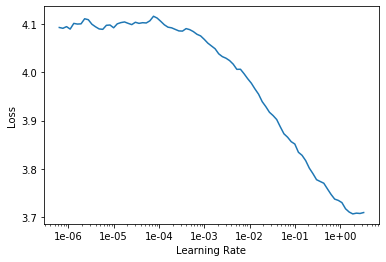

In [50]:
learner.lr_find()
learner.recorder.plot()

In [51]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.938010,3120007.000000,2.398809,1.340653,3.852784,0.780943,666664.562500,2413023.500000,40307.675781,55:02


In [34]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.880631,6511977874587648.000000,4785.763672,10200.518555,60296.972656,8978.104492,616775691534336.000000,5858159298084864.000000,37042457149440.000000,55:03


In [45]:
save_inference(learner, 'frontal_face_ae_featloss_490')

In [31]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.024809,1.912047,0.274556,0.307559,0.314175,0.059910,0.306067,0.584339,0.065441,46:12
1,1.998444,1.892993,0.264506,0.301961,0.310583,0.060517,0.298702,0.588142,0.068583,46:14
2,1.958882,1.821903,0.256612,0.296463,0.302125,0.059105,0.281105,0.562623,0.063872,46:14
3,1.890249,252266.203125,1.418088,0.657722,1.317651,0.616955,89998.531250,148616.890625,13646.083008,46:14
4,1.861910,1.763972,0.239511,0.284591,0.288509,0.058114,0.281665,0.548192,0.063390,46:16
5,1.845390,1.896723,0.329371,0.276978,0.288589,0.059108,0.309262,0.569784,0.063631,46:16
6,1.821376,1.728198,0.228764,0.280055,0.283612,0.059115,0.271216,0.542528,0.062907,46:16
7,1.776208,1.627320,0.207943,0.272493,0.272709,0.055641,0.244332,0.512900,0.061302,46:15
8,1.793175,1.602515,0.197935,0.269442,0.270440,0.055409,0.239296,0.508991,0.061002,46:16
9,1.755060,1.593937,0.197267,0.270567,0.269599,0.055300,0.235365,0.505006,0.060833,46:17


In [32]:
save_inference(learner, 'frontal_face_ae_featloss')

In [68]:
# learner.fit_one_cycle(1, 1e-3)

In [69]:
save_inference(learner, 'frontal_face_ae_featloss')

In [36]:
# learner.fit_one_cycle(10, 1e-3)

In [51]:
save_torch_inference(learner.model, '../models/face_ae_featloss.pth')

In [52]:
# learner.fit_one_cycle(1, 1e-3)

In [39]:
save_inference(learner, 'frontal_face_ae_featloss2')

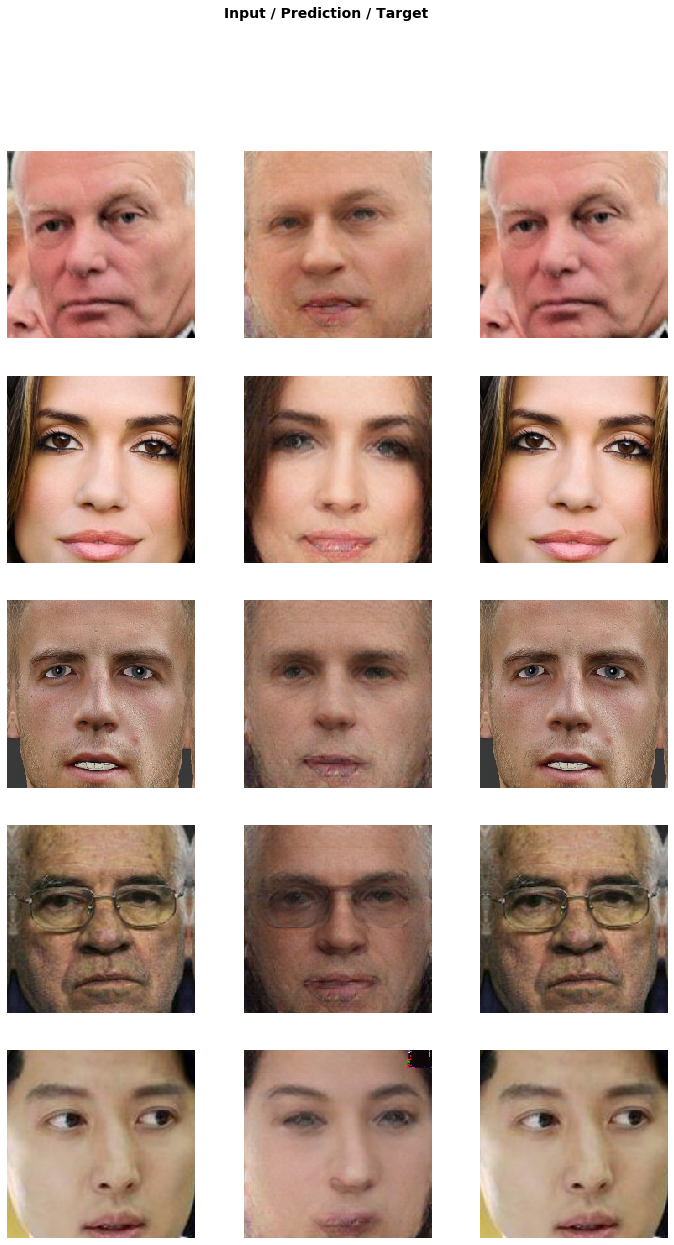

In [31]:
learner.show_results(DatasetType.Train)

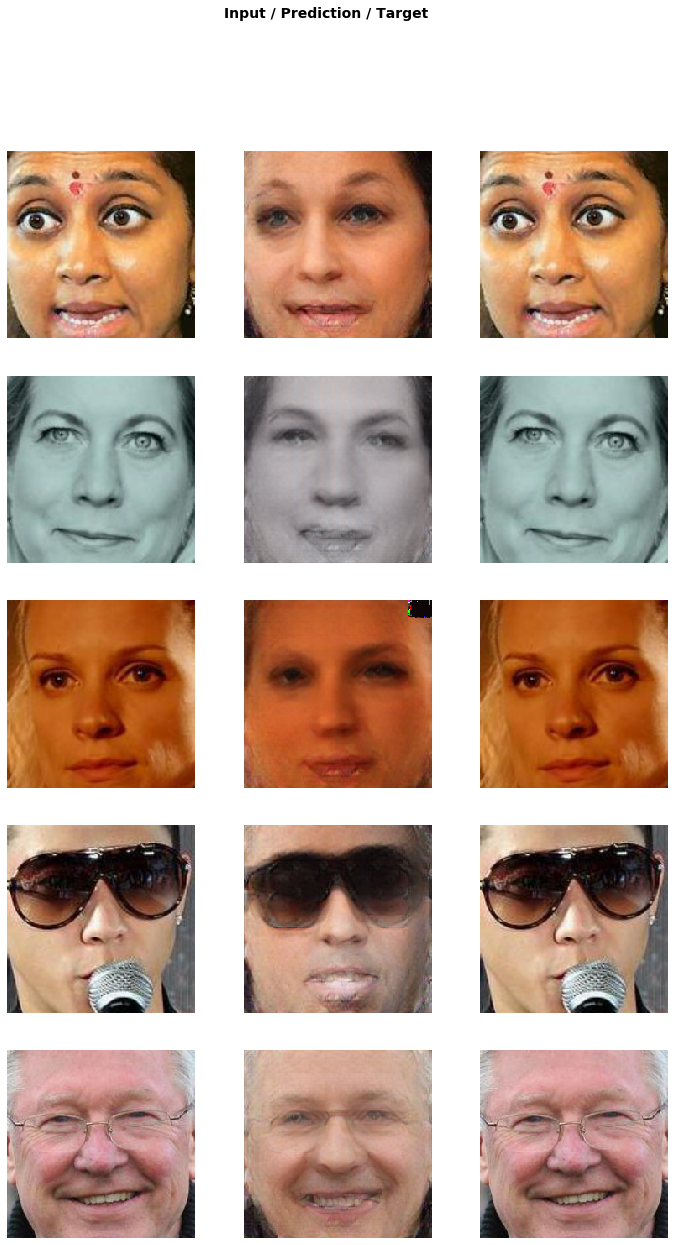

In [32]:
learner.show_results(DatasetType.Valid)

In [607]:
# learner.show_results(DatasetType.Valid, rows=10, figsize=(5,5))

# Autoencoder models

In [110]:
learner = load_inference('frontal_face_ae_featloss_490')
face_ae = learner.model[0] #.eval()
# for param in face_ae.parameters(): param.requires_grad = False
face_ae(torch.zeros(1,3,224,224).cuda()).shape

torch.Size([1, 10, 7, 7])

torch.Size([1, 10, 7, 7])

In [215]:
resnet_ae = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2]).cuda().eval()
# apply_init(resnet_ae, nn.init.kaiming_normal_)
# for param in resnet_ae.parameters(): param.requires_grad = False
resnet_ae(torch.zeros(1,3,224,224).cuda()).shape

torch.Size([1, 512, 7, 7])

In [216]:
nfs = [3,64,128,128,256,512]
random_ae = nn.Sequential(*[conv_layer(ni, nf, ks=3, stride=2) for ni,nf in zip(nfs[:-1], nfs[1:])]).cuda()
# random_ae = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()
apply_init(random_ae, nn.init.kaiming_normal_)
random_ae(torch.zeros(1,3,224,224).cuda()).shape

torch.Size([1, 512, 7, 7])

In [54]:
from facenet_pytorch import MTCNN, InceptionResnetV1
facenet_ae = InceptionResnetV1(pretrained='vggface2').eval().cuda()
facenet_ae(torch.zeros(1,3,224,224).cuda()).shape

torch.Size([1, 512])

torch.Size([1, 512])

In [111]:
test_ae, test_data = face_ae, torch.ones(4,3,224,224)
out1 = test_ae.eval()(test_data.cuda())
out2 = test_ae.eval()(test_data.cuda())
(out2 == out1).all()

tensor(True, device='cuda:0')

tensor(True, device='cuda:0')

# MouthOpen

In [112]:
src = (ImageList.from_folder('../data/icao/mouthopen_frontal_vgg/').split_by_rand_pct(0.1, seed=42).label_from_folder())
data = get_data(src, src_size, bs=4, transforms=transforms, tfm_y=False)
data

ImageDataBunch;

Train: LabelList (4024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
MouthOpen,MouthOpen,MouthOpen,MouthOpen,MouthOpen
Path: ../data/icao/mouthopen_frontal_vgg;

Valid: LabelList (447 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
MouthClosed,MouthClosed,MouthOpen,MouthOpen,MouthClosed
Path: ../data/icao/mouthopen_frontal_vgg;

Test: None

ImageDataBunch;

Train: LabelList (4024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
MouthOpen,MouthOpen,MouthOpen,MouthOpen,MouthOpen
Path: ../data/icao/mouthopen_frontal_vgg;

Valid: LabelList (447 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
MouthClosed,MouthClosed,MouthOpen,MouthOpen,MouthClosed
Path: ../data/icao/mouthopen_frontal_vgg;

Test: None

In [113]:
out2 = test_ae.eval()(test_data.cuda())
(out2 == out1).all()

tensor(True, device='cuda:0')

tensor(True, device='cuda:0')

In [114]:
# data.show_batch()

In [115]:
get_val = lambda x: tensor(test_ae.eval()(x).detach().cpu().numpy()).cuda()

In [116]:
# def get_val(x):
#     with hook_output(facenet_ae.block8) as hook:
#         facenet_ae.eval()(x)
#     return hook.stored # [1, 1792, 5, 5]

In [117]:
class AE_Model(nn.Module):
    def __init__(self, body, head):
        super().__init__()
        self.body = body
        self.head = head
    def forward(self, x):
        return self.head(self.body(x))
#         return self.head(get_val(x))
#         return self.head(self.body.eval()(x).detach())

In [118]:
# head = create_head(num_classes=data.c, zero_h=[0,1,2,3], zero_w=[0,1,5,6], body_nf=512)
head = create_head(num_classes=data.c, zero_h=None, zero_w=None, body_nf=10)
model = AE_Model(test_ae, head)

In [119]:
# learner = cnn_learner(data, models.resnet18, pretrained=False, metrics=error_rate)

In [120]:
learner = ( Learner(data, model, loss_func=CrossEntropyFlat(), metrics=error_rate, callback_fns=[ShowGraph])
            .split([model.body, model.head]) )

In [121]:
# learner.layer_groups
# learner.freeze_to(1)
# learner.unfreeze()
learner.summary()

AE_Model
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 112, 112]       432        True      
______________________________________________________________________
ReLU                 [16, 112, 112]       0          False     
______________________________________________________________________
BatchNorm2d          [16, 112, 112]       32         True      
______________________________________________________________________
Conv2d               [32, 56, 56]         4,608      True      
______________________________________________________________________
ReLU                 [32, 56, 56]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 56, 56]         64         True      
______________________________________________________________________
Conv2d               [32, 28, 28]         9,216      True      
_____________________________________________________

AE_Model
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 112, 112]       432        True      
______________________________________________________________________
ReLU                 [16, 112, 112]       0          False     
______________________________________________________________________
BatchNorm2d          [16, 112, 112]       32         True      
______________________________________________________________________
Conv2d               [32, 56, 56]         4,608      True      
______________________________________________________________________
ReLU                 [32, 56, 56]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 56, 56]         64         True      
______________________________________________________________________
Conv2d               [32, 28, 28]         9,216      True      
_____________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


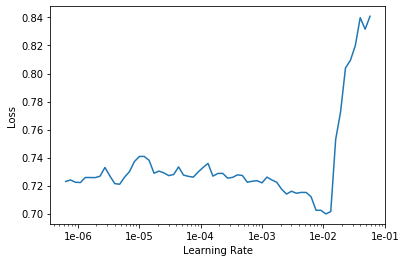

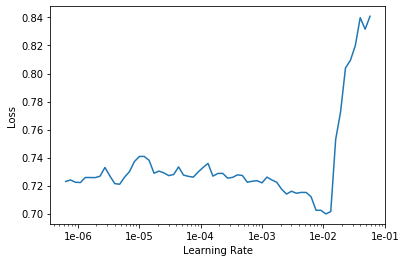

In [122]:
learner.lr_find()
learner.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,error_rate,time
0,0.594339,0.658159,0.290828,00:07
1,0.562359,0.787098,0.234899,00:07
2,0.528276,0.449229,0.192394,00:07
3,0.534052,0.465057,0.196868,00:07
4,0.461510,0.669988,0.196868,00:08
5,0.447090,0.509493,0.161074,00:08
6,0.462763,0.375894,0.178971,00:07
7,0.413725,0.324349,0.140940,00:07
8,0.483975,0.494443,0.194631,00:08
9,0.462030,0.415469,0.138702,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.594339,0.658159,0.290828,00:07
1,0.562359,0.787098,0.234899,00:07
2,0.528276,0.449229,0.192394,00:07
3,0.534052,0.465057,0.196868,00:07
4,0.461510,0.669988,0.196868,00:08
5,0.447090,0.509493,0.161074,00:08
6,0.462763,0.375894,0.178971,00:07
7,0.413725,0.324349,0.140940,00:07
8,0.483975,0.494443,0.194631,00:08
9,0.462030,0.415469,0.138702,00:08


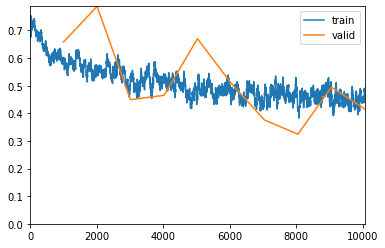

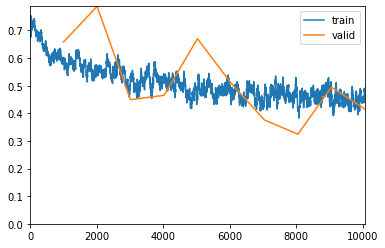

In [123]:
learner.fit(10, 1e-3)

In [221]:
# learner.fit(10, 1e-3)

In [222]:
out2 = test_ae.eval()(test_data.cuda())
(out2 == out1).all()

tensor(True, device='cuda:0')

In [117]:
out2

tensor([[ 3.1069, -2.2106, -0.4767,  ...,  0.6440, -0.6508, -0.9457],
        [ 3.1069, -2.2106, -0.4767,  ...,  0.6440, -0.6508, -0.9457],
        [ 3.1069, -2.2106, -0.4767,  ...,  0.6440, -0.6508, -0.9457],
        [ 3.1069, -2.2106, -0.4767,  ...,  0.6440, -0.6508, -0.9457]],
       device='cuda:0')

epoch,train_loss,valid_loss,error_rate,time
0,0.510917,1.467175,0.217002,00:08
1,0.558001,2.597623,0.161074,00:08
2,0.535462,0.422073,0.181208,00:08
3,0.467940,1.092874,0.228188,00:08
4,0.470332,5.657498,0.187919,00:08
5,0.515172,0.411016,0.176734,00:08
6,0.489313,0.791904,0.131991,00:08
7,0.490970,1.768635,0.143177,00:08
8,0.460929,0.542627,0.223714,00:08
9,0.428325,0.371445,0.172260,00:08


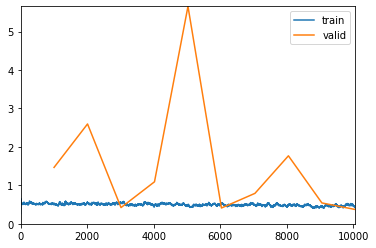

In [83]:
learner.fit(10, 1e-4)

In [85]:
save_torch_inference(head, '../models/icao_mouthopen.pth')

epoch,train_loss,valid_loss,error_rate,time
0,0.270308,0.656463,0.080537,00:15
1,0.235575,0.830094,0.080537,00:15
2,0.291616,0.818811,0.064877,00:16


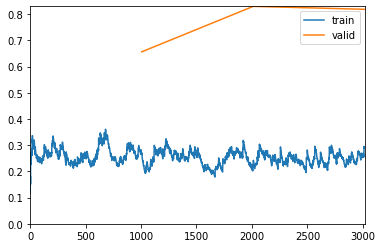

In [65]:
learner.fit(3, 1e-4)

In [67]:
# learner.fit(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.399235,0.198121,0.076063,00:15


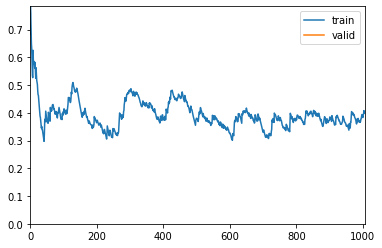

In [451]:
learner.fit(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.260916,0.184902,0.076063,00:16
1,0.282008,0.156058,0.058166,00:16
2,0.306051,0.158610,0.046980,00:15
3,0.299511,0.163250,0.049217,00:16
4,0.303280,0.143817,0.044743,00:16
5,0.212699,0.157930,0.064877,00:15
6,0.268746,0.160279,0.058166,00:16
7,0.264602,0.152588,0.062640,00:16
8,0.254131,0.149216,0.060403,00:16
9,0.284445,0.145501,0.058166,00:16


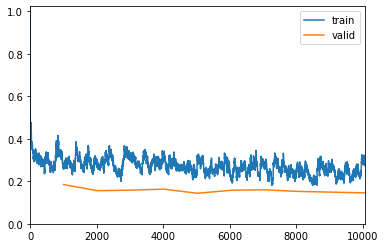

In [452]:
learner.fit(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.293606,0.183251,0.062640,00:19
1,0.309093,0.213542,0.076063,00:19
2,0.261400,0.180019,0.062640,00:18
3,0.293794,0.179218,0.058166,00:19
4,0.168567,0.210961,0.078300,00:18
5,0.263770,0.194497,0.073826,00:19
6,0.167873,0.213433,0.080537,00:18
7,0.214136,0.293876,0.089485,00:18
8,0.143757,0.202670,0.071588,00:18
9,0.175687,0.198314,0.071588,00:19


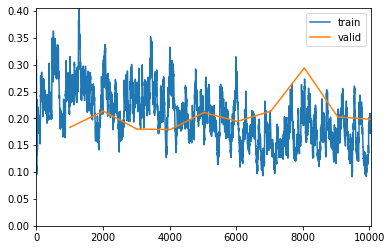

In [444]:
learner.fit(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.163348,0.255179,0.078300,00:19
1,0.126178,0.221514,0.069351,00:19
2,0.171722,0.235524,0.080537,00:19
3,0.173556,0.212086,0.076063,00:18
4,0.118539,0.223597,0.073826,00:18
5,0.071659,0.269616,0.076063,00:18
6,0.132477,0.199363,0.076063,00:18
7,0.154451,0.213348,0.076063,00:19
8,0.157705,0.243367,0.082774,00:19
9,0.202532,0.215882,0.076063,00:19


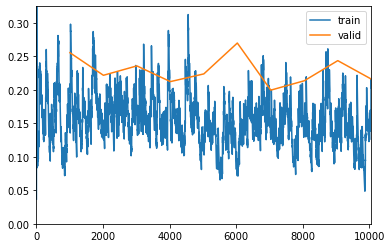

In [445]:
learner.fit(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.408801,0.280608,0.115333,01:49


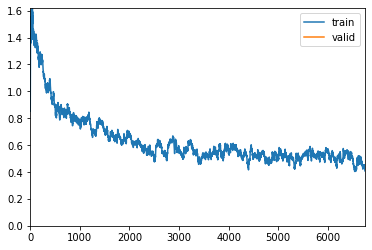

In [391]:
learner.fit(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.362061,0.291954,0.103667,01:50
1,0.406810,0.260283,0.091667,01:50
2,0.324136,0.262961,0.094667,01:52
3,0.281558,0.231135,0.090333,01:49
4,0.279085,0.210696,0.087333,01:50
5,0.359341,0.237019,0.082000,01:51
6,0.272654,0.219426,0.083667,01:47
7,0.329385,0.219114,0.087333,01:49
8,0.304675,0.220680,0.096000,01:52
9,0.319635,0.208613,0.081667,01:52


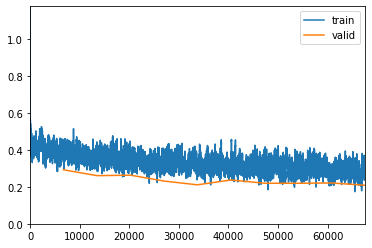

In [392]:
learner.fit(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.474430,0.366479,0.150000,01:36
1,0.435922,0.359121,0.143667,01:32
2,0.463024,0.352370,0.138667,01:39
3,0.419775,0.344218,0.136667,01:36
4,0.466208,0.323713,0.125333,01:34
5,0.437425,0.333018,0.123667,01:38
6,0.396209,0.328019,0.124333,01:33
7,0.384791,0.319021,0.121000,01:36
8,0.436371,0.304108,0.111333,01:38
9,0.430966,0.303375,0.117333,01:38


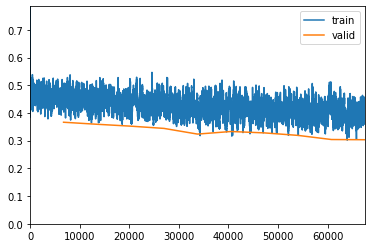

In [353]:
learner.fit(10, 1e-4)

In [354]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [357]:
interp.most_confused()

[('MouthOpen', 'MouthClosed', 255), ('MouthClosed', 'MouthOpen', 97)]

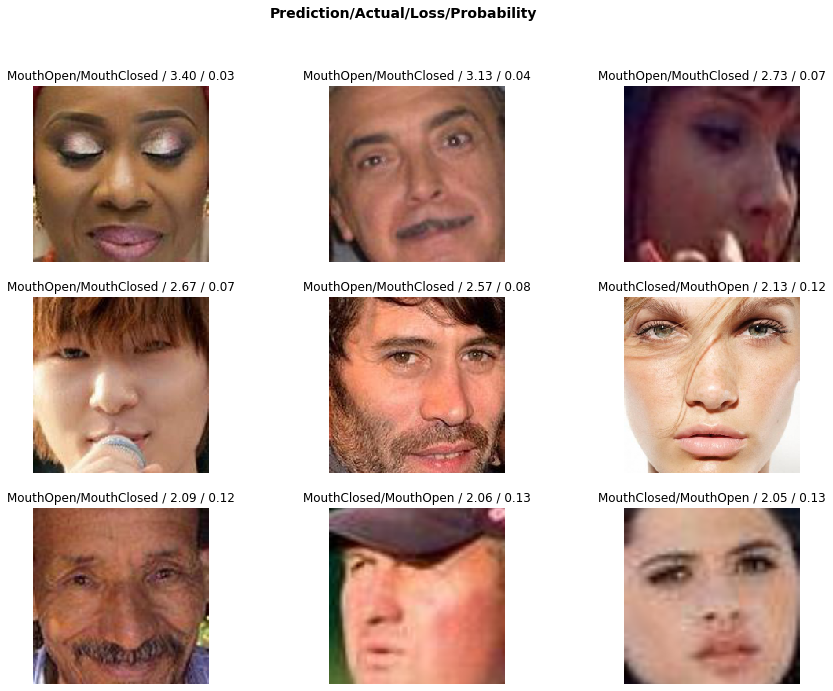

In [355]:
interp.plot_top_losses(9, figsize=(15,11))

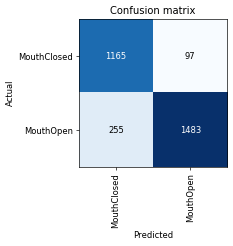

In [358]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

epoch,train_loss,valid_loss,error_rate,time
0,0.439700,0.362845,0.139000,01:33


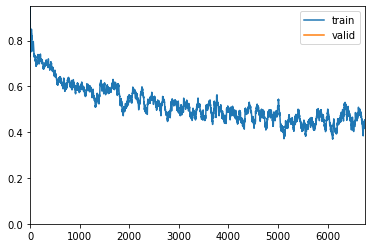

In [82]:
learner.fit(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.578059,0.572488,0.290667,01:37


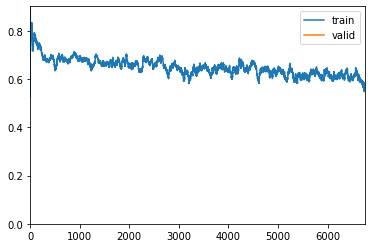

In [106]:
learner.fit(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.365516,0.287863,0.113333,01:32
1,0.382432,0.291038,0.111667,01:30
2,0.371540,0.278928,0.109333,01:29
3,0.433950,0.284425,0.110000,01:29
4,0.349607,0.282482,0.109000,01:32
5,0.319272,0.264600,0.109000,01:30
6,0.346694,0.254358,0.100333,01:32
7,0.385660,0.256047,0.107333,01:29
8,0.354538,0.284803,0.106667,01:26
9,0.356383,0.258767,0.102667,01:25


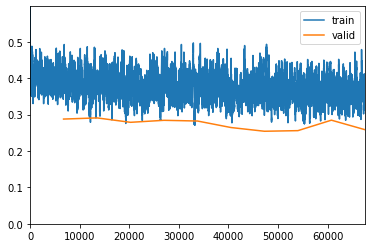

In [585]:
learner.fit(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.499113,0.413147,0.176667,01:32
1,0.436666,0.398797,0.164000,01:31
2,0.458743,0.409881,0.171000,01:30
3,0.444812,0.386119,0.163000,01:29
4,0.474333,0.380675,0.157333,01:27
5,0.482438,0.380033,0.164333,01:33
6,0.459908,0.375954,0.156333,01:31
7,0.442707,0.368566,0.153000,01:31
8,0.455102,0.358624,0.151000,01:26
9,0.422895,0.366475,0.145667,01:32


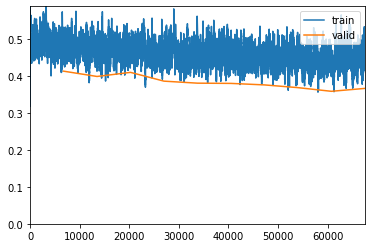

In [579]:
learner.fit(10, 1e-4)

In [555]:
learner.fit(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.392540,0.320851,0.123667,01:28
